# Applications of Regression

## Load the dataset

In [1]:
import pandas as pd
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/My Drive/Colab Notebooks/' #default for all

path = root+'Module4 - Regression/'#(file location in gdrive)


Mounted at /content/drive


The code in the cell below loads the dataset which was prepared using steps from the Data Preparation lab.Execute this code and ensure that the expected columns are present. 

In [5]:
df = pd.read_csv('Auto_Data_Preped.csv')
df.columns

Index(['symboling', 'make', 'fuel_type', 'aspiration', 'num_of_doors',
       'body_style', 'drive_wheels', 'engine_location', 'wheel_base', 'length',
       'width', 'height', 'curb_weight', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio',
       'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price',
       'log_price'],
      dtype='object')

In [6]:
df.skew()

<ipython-input-6-9e0b1e29546f>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew()


symboling            0.213727
wheel_base           0.985295
length               0.140269
width                0.867393
height               0.033528
curb_weight          0.678770
engine_size          2.027883
bore                -0.018909
stroke              -0.761724
compression_ratio    2.532037
horsepower           1.143442
peak_rpm             0.096658
city_mpg             0.664775
highway_mpg          0.524295
price                1.776886
log_price            0.674593
dtype: float64

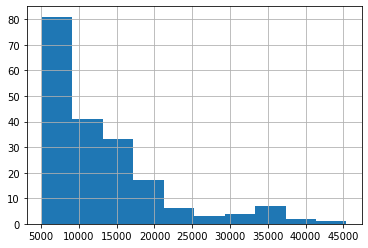

In [7]:
df['price'].hist()

0.6746673155897839


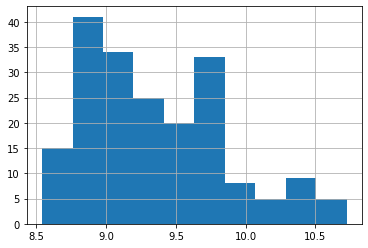

In [ ]:
log_price = np.log1p(df.price)
log_price.hist()
print(log_price.skew())

In [8]:
def bin_check(y):
  if y.dtype != 'O':
    ival = y.describe().values[2]; #print(ival)
    b = []
    for i in range(0,int(max(y)),int(ival)):b.append(i); # print(b)
    y_bin = pd.cut(y, bins=b,labels=[i for i in range(len(b)-1)])
  else:
    y_bin = y 
  return y_bin

def feature_analysis(x,y):
  x=x.dropna()
  x['y']=bin_check(y)
  feature_scores={}
  for col in x.columns:
    if col == 'y': continue 
    if x[col].dtype != 'O':
      feature_scores[col]=abs(np.corrcoef(y,x[col])[0][1])

    else:
      gx = x.groupby([col,'y'])['y'].count()
      gxr = gx/len(x)
      fgx = gxr[gxr.values>0.05]

      ix = fgx.index
      clist={}
      for c, yb in ix:
        if c not in clist: clist[c] = []
        clist[c].append(yb)
      availability = len(clist)/len(x[col].unique())
      penalty=[]
      for k, v in clist.items():
        penalty.append(1/len(v))
      avg_penalty = np.mean(np.array(penalty))
      ns = availability*avg_penalty
      feature_scores[col]=ns
  return feature_scores

fs = feature_analysis(df,df.price)
fs

{'symboling': 0.0841176470533275,
 'make': 0.023809523809523808,
 'fuel_type': 0.16666666666666666,
 'aspiration': 0.41666666666666663,
 'num_of_doors': 0.2222222222222222,
 'body_style': 0.45833333333333326,
 'drive_wheels': 0.3333333333333333,
 'engine_location': 0.16666666666666666,
 'wheel_base': 0.5857928303921185,
 'length': 0.6953308343938747,
 'width': 0.7542733859108733,
 'height': 0.13829068882904838,
 'curb_weight': 0.835729341509727,
 'engine_type': 0.06666666666666667,
 'num_of_cylinders': 0.4444444444444444,
 'engine_size': 0.8889422569129037,
 'fuel_system': 0.14285714285714285,
 'bore': 0.5468729166865851,
 'stroke': 0.09374643867924778,
 'compression_ratio': 0.06950020493406844,
 'horsepower': 0.8110268356667207,
 'peak_rpm': 0.10433339530640258,
 'city_mpg': 0.7026848539940072,
 'highway_mpg': 0.7155897581108311,
 'price': 0.9999999999999999,
 'log_price': 0.957443202289307}

In [ ]:
bin_check(df.body_style)

0      hardtop_convert
1      hardtop_convert
2            hatchback
3                sedan
4                sedan
            ...       
190              sedan
191              sedan
192              sedan
193              sedan
194              sedan
Name: body_style, Length: 195, dtype: object

In [9]:
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,log_price
0,3,alfa-romero,gas,std,two,hardtop_convert,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495,9.510075
1,3,alfa-romero,gas,std,two,hardtop_convert,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500,9.711116
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500,9.711116
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950,9.543235
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450,9.767095


Notice that there are both numeric and categorical features. 

In [10]:
from math import log, log10, log2, log1p
log(13495)

9.510074525452104

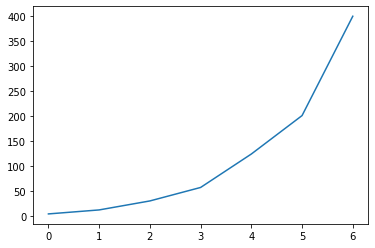

In [11]:
lx = np.array([4,12,30,57,124,201,400])
plt.plot(lx)
plt.show()

[1.38629436 2.48490665 3.40119738 4.04305127 4.82028157 5.30330491
 5.99146455]


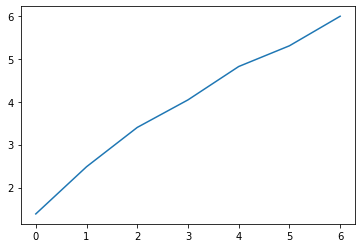

In [12]:
lxlog = np.log(lx)
print(lxlog)
plt.plot(lxlog)
plt.show()

In [13]:
np.exp(lxlog)

array([  4.,  12.,  30.,  57., 124., 201., 400.])

In [14]:
df.describe()

,symboling,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,log_price
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.794872,98.896410,174.256923,65.886154,53.861538,2559.000000,127.938462,3.329385,3.250308,10.194974,103.271795,5099.487179,25.374359,30.841026,13248.015385,9.349624
std,1.230612,6.132038,12.476443,2.132484,2.396778,524.715799,41.433916,0.271866,0.314115,4.062109,37.869730,468.271381,6.401382,6.829315,8056.330093,0.508971
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000,8.540519
25%,0.000000,94.500000,166.300000,64.050000,52.000000,2145.000000,98.000000,3.150000,3.110000,8.500000,70.000000,4800.000000,19.500000,25.000000,7756.500000,8.956284
50%,1.000000,97.000000,173.200000,65.400000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5100.000000,25.000000,30.000000,10245.000000,9.234545
75%,2.000000,102.400000,184.050000,66.900000,55.650000,2943.500000,145.500000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,35.000000,16509.000000,9.711661
max,3.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000,45400.000000,10.723267


In [15]:

df.describe(include="object")

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,engine_type,num_of_cylinders,fuel_system
count,195,195,195,195,195,195,195,195,195,195
unique,21,2,2,3,4,3,2,5,3,7
top,toyota,gas,std,four,sedan,fwd,front,ohc,three_four,mpfi
freq,32,175,159,112,94,116,192,143,156,89


In [16]:
cc = np.corrcoef(df.log_price,df.engine_size)
print(cc)
print(cc[0][1])

[[1.         0.85274745]
 [0.85274745 1.        ]]
0.8527474546090629


## Prepare the model matrix.

All scikit-learn models require a numpy array of numeric only values for the features. The resulting array is often referred to as the **model matrix**.  

### Create dummy variables from categorical features

 There is one dummy variable for each possible category. For each case all of the values in the dummy variables are set to zero, except the one corresponding to the category value, which is set to one. In this way, a categorical variable with any number of categories can be encoded as series of numeric features which scikit-learn can operate on. This process is referred to as **one hot encoding** since only one dummy variable is coded as 1 (hot) per case. 

The `sklearn.preprocessing` package contains functions to encode categorical features as dummy variables in two steps;
1. The categories are  encoded as numbers starting with 0.
2. The numeric categories are then encoded as dummy variables. 

The following example will give you a feel for how this process works. The code in the cell below computes the numeric representation of the categories for the `body_style` feature by the following steps:

1. An encoder object is created using the `LabelEncoder` method.
2. The encoder is `fit` to the unique string values of the feature. 
3. The `transformation` method then applies the numeric encoding to the original feature. 

Execute the code in the cell below and examine the result. 

In [ ]:
ordinal_labels = {'high':3, 'medium':2, 'low':1}

In [17]:
print(df['body_style'].unique())
Features = df['body_style']
enc = preprocessing.LabelEncoder()
enc.fit(Features)
Features = enc.transform(Features)
print(Features)

['hardtop_convert' 'hatchback' 'sedan' 'wagon']
[0 0 1 2 2 2 2 3 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1 1 2 2 2 3 1 1 1 1 1 1 2 3 1
 1 2 2 2 2 2 1 2 2 2 1 1 1 2 2 1 2 1 2 2 1 2 2 2 3 0 2 2 0 2 0 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 3 2 1 2 3 0 1 2 2 3 2 1 1 1 2 2 3 3 2 2 3 3 2 2 2
 1 1 1 2 2 3 1 1 0 0 0 1 2 1 2 1 2 1 1 1 2 2 2 2 2 3 3 3 3 1 1 1 3 3 3 2 1
 2 1 2 1 2 2 1 2 1 0 0 1 0 1 0 2 2 1 2 1 1 1 2 3 2 2 2 2 2 2 2 0 1 2 2 3 2
 3 2 3 2 3 2 2 2 2 2]


For the next step in the process, the numerically coded categorical variable is converted to a set of dummy variables following these steps:
1. A one hot encoder object is created using the `OneHotEncoder` method from the `sklearn.preprocessing` module.
2. The numerically coded categorical feature is fit with the one hot encoder. 
3. The dummy variables are encoded using the `transform` method on the encodings.

Execute the code in the cell below and examine the result. 

In [18]:
print(Features.shape)
print(Features[:5])

(195,)
[0 0 1 2 2]


In [19]:
Features = Features.reshape(-1,1)
print(Features.shape)
print(Features[:5])

(195, 1)
[[0]
 [0]
 [1]
 [2]
 [2]]


In [20]:
ohe = preprocessing.OneHotEncoder()
encoded = ohe.fit(Features)
oheFeatures = encoded.transform(Features).toarray()
print(oheFeatures[:10, :])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [21]:
#multi dimension slicing for example only
oheFeatures[:5, :3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

Notice that the `body_style` feature has been encoded as five columns. Each of these columns is a dummy variable representing one category. Each row has one and only one dummy variable with a 1, and the rest 0s. This is the one hot encoding. 

Now, you need to one hot encode all five categorical variables and append them as columns to the model matrix with the scaled numeric variables. The code in the cell below executes a `for` loop that calls the `encode_string` function and uses the numpy `concatenate` function to add the dummy variables to the model matrix. The `encode_string` function uses the same process discussed above. 

Execute this code, verify the result, and answer **Question 1** on the course page.

In [22]:
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    oheFeatures = encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()
    return oheFeatures
  

In [23]:
categorical_columns = ['fuel_type', 'aspiration', 'drive_wheels', 'num_of_cylinders']

for col in categorical_columns:
    print(df[col].unique())
    temp = encode_string(df[col])
    Features = np.concatenate([oheFeatures, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

['gas' 'diesel']
['std' 'turbo']
['rwd' 'fwd' '4wd']
['three_four' 'five_six' 'eight_twelve']
(195, 7)
[[1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1.]]


Notice that the model matrix now has 14 features which encode the five origianalcategorical features. 

### Add the numeric features

To complete the model matrix, execute the code in the cell below to concatenate the three numeric features.

In [24]:
Features = np.concatenate([Features, np.array(df[['curb_weight', 'horsepower', 'city_mpg']])], axis = 1)
Features[:2,:]

array([[1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.548e+03, 1.110e+02, 2.100e+01],
       [1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.548e+03, 1.110e+02, 2.100e+01]])

There are now 17 features, 14 dummy variables and 3 numeric features. 

## Split the dataset

With the model matrix constructed, you must now create randomly sampled training and test data sets. The code in the cell below uses the `train_test_split` function from the `sklearn.model_selection` module to Bernoulli sample the cases in the original dataset into the two subsets. Since this data set is small only 40 cases will be included in the test dataset. Execute this code. 

In [25]:
## Randomly sample cases to create independent training and test data
labels = np.array(df['price'])
x_train,x_test,y_train,y_test = ms.train_test_split(Features, labels)

In [26]:
print(x_train.shape)
print(x_test.shape)

(146, 10)
(49, 10)


### Rescale numeric features

In [27]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
print(x_train.shape)
x_train[:5,:]

(146, 10)


array([[-0.27116307,  1.47441956, -0.98639392, -0.375     , -0.14484136,
        -0.46547467,  0.49785866, -1.18716094, -0.68939239,  0.74490988],
       [-0.27116307, -0.678233  , -0.98639392,  2.66666667, -0.14484136,
        -0.46547467,  0.49785866,  0.92072239,  0.28880428, -0.38629056],
       [-0.27116307, -0.678233  , -0.98639392,  2.66666667, -0.14484136,
        -0.46547467,  0.49785866, -0.53406908, -0.53494028,  0.42170975],
       [-0.27116307, -0.678233  ,  1.01379376, -0.375     , -0.14484136,
        -0.46547467,  0.49785866, -1.19889313, -0.89532853,  0.90650994],
       [-0.27116307,  1.47441956, -0.98639392, -0.375     , -0.14484136,
        -0.46547467,  0.49785866, -0.27009482, -0.48345625,  0.09850963]])

You can see that the numeric features have been rescaled are required. 

## Construct the linear regression model

In [28]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression(fit_intercept = False)
lin_mod.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

In [29]:
print(lin_mod.intercept_)
print(lin_mod.coef_)

0.0
[ 1263.68262245  -519.07085196   270.61658582  -648.96607467
  1382.76155551   648.04021098 -1113.10466217  3543.62088606
  2241.75105699   601.08423686]


As expected, the intercept term is `0.0`. Roughly speaking, you can interpret the coefficients of the model as follows:  
1. The price of autos increases with weight (first coefficient), horsepower (second coefficient) and weakly decreases with fuel efficiency (third coefficient). 
2. The coefficients for the dummy variables are in a similar range, indicating the bias or intercept has been incorporated in these. 

## Evaluate the model

You will now use the test dataset to evaluate the performance of the regression model. As a first step, execute the code in the cell below to compute and display various performance metrics and examine the results. Then, answer **Question 2** on the course page.

In [30]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(x_test) 
print_metrics(y_test, y_score, 28)    

Mean Square Error      = 177184358.96845946
Root Mean Square Error = 13311.061526732548
Mean Absolute Error    = 12930.23052456211
Median Absolute Error  = 13007.718703442228
R^2                    = -1.8670012314011637
Adjusted R^2           = -5.553145671774089


At first glance, these metrics look promising. The RMSE, MAE and median absolute error are all small and in a similar range. However, notice that the $R^2$ and $R^2_{adj}$ are rather different. This model has a large number of parameters compared to the number of cases available. This result indicates that the model may be overfit and might not generalize well. 

To continue the evaluation of the model performance, execute the code in the cell below to display a histogram of the residuals. 

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


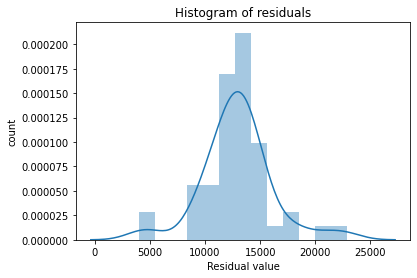

In [31]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)    

This histogram shows that the residuals are in a small range. However, there is some noticeable skew in the distribution. 

Next, execute the code in the cell below to display the Q-Q Normal plot. 

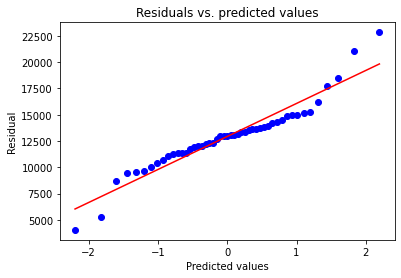

In [32]:
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, y_score)   

As with the histogram, the Q-Q Normal plot indicates the residuals are close to Normally distributed, show some skew (deviation from the straight line). This is particularly for large residuals. 

There is one more diagnostic plot. Execute the code in the cell below to display the plot of residuals vs. predicted values. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


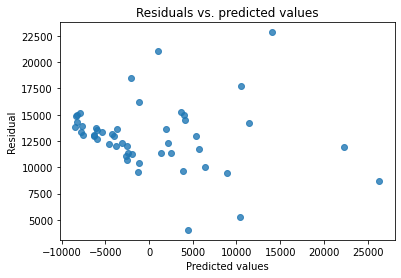

In [33]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score) 

This plot looks reasonable. The residual values appear to have a fairly constant dispersion as the predicted value changes. A few large residuals are noticeable, particularly on the positive side. 

In [35]:
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
resid_plot(y_test_untransform, y_score_untransform) 

Notice that the untransformed residuals show a definite trend. The dispersion of the residuals has a cone-like pattern increasing to the right. The regression model seems to do a good job of predicting the price of low cost cars, but becomes progressively worse as the price of the car increases. 

## Summary

1. Transformed the label value to make it more symmetric and closer to a Normal distribution.
2. Aggregated categories of a categorical variable to improve the statistical representation. 
3. Scaled the numeric features. 
4. Recoded the categorical features as binary dummy variables. 
5. Fit the linear regression model using scikit-learn. 
6. Evaluated the performance of the model using both numeric and graphical methods. 

It is clear from the outcome of the performance evaluation that this model needs to be improved. As it is, the model shows poor generalization. 